# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 марта, -4 балла после 06:00 13 марта, -6 баллов после 06:00 20 марта

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.</br> При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

#### Задание 1 (5 баллов)

Имплементируйте метод k-means

In [361]:
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import cdist

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        
    def fit(self, X):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора псевдослучайных чисел
        np.random.seed(self.random_state)
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        # 1. initialize centroids by randomly chosen points
        # XXX: unlike R's, pandas' DataFrames don't like to be indexed even by lists
        self.centroids = X[np.random.choice(xrange(0,X.shape[0]),self.k),:]
        
        for iter in xrange(0,self.max_iter):
            prev_labels = self.labels
            
            # 2. assign labels to points
            self.labels = self.predict(X)
            
            # 3. compute new centroids
            for clus in xrange(0,self.k):
                self.centroids[clus] = np.mean(X[self.labels == clus,:],axis=0)

            if np.all(prev_labels == self.labels): # 4. stop if no change in assigned classes
                break # this also means that centroids remain same
        
        return self

    def predict(self, X):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        # this is exactly (2) from the fitting algorithm
        labels = np.empty(X.shape[0])

        distance_matrix = cdist(X,self.centroids,self.metric) # shaped (X.shape[0], k)
        for point in xrange(0,X.shape[0]): # mirror, mirror on the wall,
            labels[point] = distance_matrix[point,:].argsort()[0] # who's the closest of them all?
        
        return labels

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, желатено испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

In [362]:
from sklearn.datasets import make_blobs

In [363]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

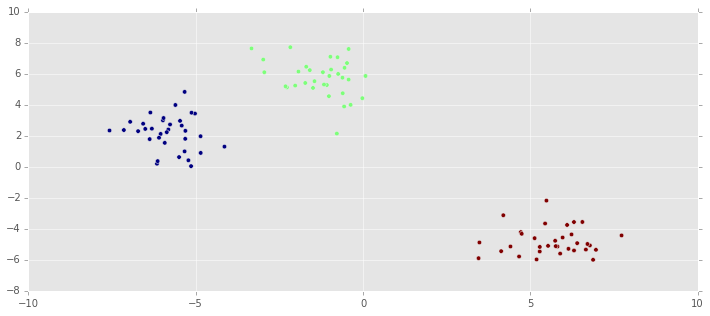

In [364]:
plt.scatter(X[:,0], X[:, 1], c=y)

#### Задание 2 (1 балл) 

Проверьте вашу имплементацию на простых данных

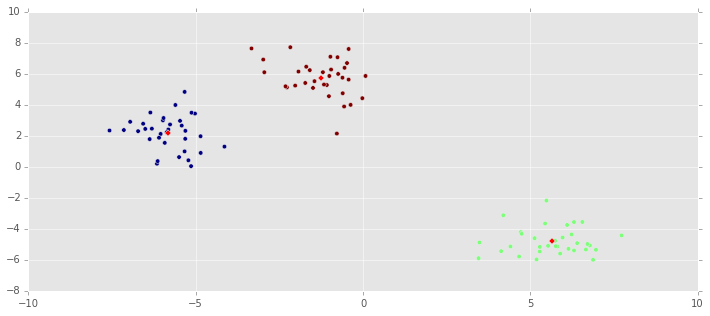

In [365]:
predicted = Kmeans(k=3,random_state=1234).fit(X)
plt.scatter(X[:,0], X[:, 1], marker="o", c=predicted.labels)
plt.scatter(
    x=predicted.centroids[:,0],
    y=predicted.centroids[:,1],
    marker="D",
    c="#FF0000"
);

# Применение K-means на реальных данных

In [366]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

#### Задание 3 (4 балла)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)

In [367]:
# remove the uninteresting columns
for col in ['gradyear','gender','age','friends']: del df_sns[col]

df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [368]:
# normalize
for col in df_sns.columns:
    df_sns[col] = (df_sns[col] - df_sns[col].mean())/df_sns[col].var()
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
1,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,1.534117,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
2,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,4.642616,-0.552206,-0.506205
3,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205
4,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.026224,-0.531663,3.138686,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,5.725238,7.870048


In [369]:
# split into 9 clusters
# strictly speaking, I can't exactly classify a person with NA in variables
%time clusters = Kmeans(k=9,random_state=262144).fit(np.array(df_sns.dropna()))
# random_state=262144 yields a 2e4-sized cluster, which is better than the most other numbers I tried
clustered = pd.concat([df_sns.dropna(), pd.DataFrame(clusters.labels,columns=["cluster"])],axis=1) 
clustered.head()

CPU times: user 2.9 s, sys: 0 ns, total: 2.9 s
Wall time: 2.89 s


,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,cluster
0,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205,4.0
1,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,1.534117,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205,0.0
2,-0.412835,1.502830,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,4.642616,-0.552206,-0.506205,7.0
3,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,-0.672712,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,-0.552206,-0.506205,4.0
4,-0.412835,-0.507107,-0.264788,-0.294609,-0.349509,-0.502846,-0.403092,-0.385504,-0.326787,-0.630717,...,-0.531663,3.138686,-0.664761,-0.580983,-0.654713,-0.472027,-0.598737,5.725238,7.870048,6.0


In [370]:
print clustered.groupby("cluster").apply(lambda x: x.set_index("cluster").mean().nlargest(7))
print clustered.groupby("cluster").apply(lambda x: x.set_index("cluster").mean().nsmallest(5))
print clustered.groupby("cluster").apply(lambda x: x.count().values[0])

cluster              
0.0      dress            6.812569
         clothes          0.520196
         shopping         0.516669
         mall             0.384571
         cute             0.376492
         dance            0.321287
         church           0.235189
1.0      bible           31.685037
         jesus            2.548253
         church           1.317365
         god              1.056665
         drugs            0.585572
         death            0.510011
         kissed           0.368191
2.0      abercrombie     15.003609
         hollister        7.321979
         clothes          1.142407
         shopping         1.027832
         hot              0.756391
         cheerleading     0.754168
         mall             0.721010
3.0      drunk           15.315357
         kissed           2.537325
         sex              0.876414
         hair             0.832792
         clothes          0.802238
         die              0.757443
         drugs            0.74518

## Кластеры:

0. Шопоголики, интересуются покупкой миленькой одежды.
1. Христиане. Читают библию, обсуждают Иисуса, ходят в церковь и выступают против наркотиков.
2. Тоже интересуются покупкой одежды, но не миленькой, [а](https://www.hollisterco.com/shop/wd) [брендовой](https://www.abercrombie.com/shop/wd).
3. Чемпионы литрбола и прочих [сомнительных занятий](http://after12.failblog.org/), специфичных для вечеринок.
4. Серая масса, которой больше всего и которая ничем особенно не интересуется, кроме блондинок и футбола, а ещё изредка вспоминает, что верит в бога.
5. Спортивные фанаты.
6. Участники ещё более ужасных вечеринок, чем (3).
7. Люди, которые считают, что находятся на полпути на шоссе в ад и склонны думать о боли, смерти и тяжёлой музыке, но на самом деле это возрастное и пройдёт.
8. Участники [марширующих оркестров](https://en.wikipedia.org/wiki/Marching_band), имеющие более-менее профессиональное представление о музыке.